In [1]:
#import cupy
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
from scipy import signal
import os
from PIL import Image
import numpy as np
%matplotlib inline

j= 0
j= 1
j= 2


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff2d5c0e978>,
 <matplotlib.image.AxesImage at 0x7ff2d5b846a0>)

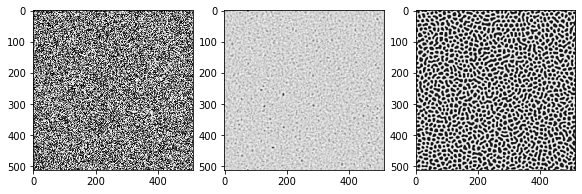

In [0]:
#磁気ドメインパターン形成TDGL方程式 多くのファイルを生成
#初期値の用意
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
from scipy import signal
import os
%matplotlib inline

Phi_r_ini=np.ones([500,512,512],dtype=np.complex)
Phi_r=Phi_r_ini+0.1*np.random.rand(512,512)
Phi_k=np.zeros([500,512,512],dtype=np.complex)
Sum_Moment=np.zeros(500)
diff_Moment=np.zeros(500)
Real_Phi_r=np.zeros([500,512,512])
Mag_Field=np.zeros(500)
repetition=3

#時間ステップの用意
delta_t=0.1

#betaの用意
beta=4.0 #デフォ
#beta=3

#alphaの用意
alpha=2.5#デフォ
#alpha=1.6

#gammaの用意
gamma=2.0/np.pi#デフォ

#k=(k_x,k_y)の用意
k_x=np.linspace(0,511,512)
for i in range(len(k_x)):
    if i>len(k_x)//2:
        k_x[i]=k_x[i]-len(k_x)
    else:
        k_x[i]=k_x[i]

k_y=copy.copy(k_x)
kk_sqrt=np.zeros([512,512])
for i in range(512):
    for j in range(512):
        kk_sqrt[j,i]=np.sqrt(4.0*np.pi**2*k_x[i]*k_x[i]/(len(k_x)*len(k_x))+4.0*np.pi**2*k_y[j]*k_y[j]/(len(k_x)*len(k_x)))

        #ここはkの絶対値PRE(6)式


#1/(1+beta*(k_x^2+k_y^2)*delta_t)
keisu=np.zeros([512,512])
for i in range(512):
    for j in range(512):
        keisu[j,i]=1/(1+beta*(4.0*np.pi**2*k_x[i]*k_x[i]/(len(k_x)*len(k_x))+4.0*np.pi**2*k_y[j]*k_y[j]/(len(k_x)*len(k_x)))*delta_t)

#keisu=Lambda*keisu        

#Lambda_ini=np.ones([512,512])
Lambda_ini=np.ones([512,512])
myu_0=0.3
#np.random.seed(10)

Lambda=Lambda_ini+0.25*np.random.normal(0, myu_0, (512,512))
Lambda_FFT=np.fft.fft2(Lambda)
#Lambda_k_shift=np.fft.fftshift(Lambda_FFT)

#Lambda_arr=np.loadtxt('testM.txt')#磁気異方性が完全ランダムではないときは？
#Lambda_arr_Norm=Lambda_arr/255
#Lambda=(Lambda_ini+Lambda_arr_Norm)*0.25*np.random.normal(0, myu_0, (512,512))
#Lambda=Lambda_ini+0.25*Lambda_arr_Norm

#a0,a1の用意
a0=4.0
a1=2.0*np.pi

#G_kの用意
G_k=np.zeros([512,512])
G_k=a0-a1*kk_sqrt

#磁場の用意
h_ini_r=1.4
#h_ini_r=10
Mag_Field[0]=h_ini_r
h=np.ones([512,512])
h=h_ini_r*h
#print(h)
H_k=np.fft.fft2(h)
v=np.ones([512,512])
h_v=0.0100*v

#初期磁化の値
Real_Phi_r[0,:,:]=np.real(Phi_r[0,:,:])
Sum_Moment[0]=np.sum(Real_Phi_r[0,:,:])/len(k_x)**2

#JPSJ(2005)013002.(7)式の用意:時刻t=0のもの
Phi_r3=Phi_r[0,:,:]*Phi_r[0,:,:]*Phi_r[0,:,:]
First=Lambda*(Phi_r[0,:,:]-Phi_r3)
#First=(Phi_r[0,:,:]-Phi_r3)

#上式のFFT　ここのたたみ込みの計算を位相移動法で行う→打ち切り法へ変更(2019/05/27)-len(k_x)/2, len(k_x)/2
First_FFT=np.fft.fft2(First)
Phi_k[0,:,:]=np.fft.fft2(Phi_r[0,:,:])
for l in range(-256,256):
    for k in range(-256,256):
        if k**2+l**2 > 170**2:
            First_FFT[k,l]=0.0+0.0j
        else:
            First_FFT[k,l]=First_FFT[k,l]

#時刻t+ΔtのPhi_k k=(k_x,k_y)とk^2=k_x^2+k_y^2これの平方根sを用意する

for j in range(repetition):
    print("j=",j)
    if j==0:
        Phi_k_temp=Phi_k[0,:,:]
        Phi_k[0,:,:]=Phi_k_temp
    else:
        Phi_k_temp=Phi_k[i+1,:,:]
        Phi_k[0,:,:]=Phi_k_temp
        Sum_Moment_temp=Sum_Moment[i+1]
        Sum_Moment[0]=Sum_Moment_temp
        diff_Moment_temp=diff_Moment[i+1]
        diff_Moment[0]=diff_Moment_temp
        Mag_Field_temp=Mag_Field[i+1]
        Mag_Field[0] = Mag_Field_temp

    for i in range(499):
        #print("i=",i)
        Phi_k[i+1,:,:]=keisu*(delta_t*(alpha*First_FFT+H_k-gamma*G_k*Phi_k[i,:,:])+Phi_k[i,:,:])
        Phi_r[i+1,:,:]=np.fft.ifft2(Phi_k[i+1,:,:])
        #print('Phi_r[i+1,:,:]=',Phi_r[i+1,:,:])
        #境界条件＆周期境界
        #Phi_r[i+1,0:511,511]=Phi_r[i+1,0:511,0]
        #Phi_r[i+1,0,0:511]=Phi_r[i+1,0:511,0]
        #Phi_r[i+1,511,0:511]=Phi_r[i+1,0,0:511]
        
        #Phi_r[i+1,1:510,511]=Phi_r[i+1,1:510,0]
        #Phi_r[i+1,511,511]=Phi_r[i+1,0,0]
        #Phi_r[i+1,0,511]=Phi_r[i+1,0,0]

        Phi_r[i+1,511,1:510]=Phi_r[i+1,0,1:510]
        Phi_r[i+1,1:510,511]=Phi_r[i+1,1:510,0]
        Phi_r[i+1,511,511]=Phi_r[i+1,0,0]
        Phi_r[i+1,0,511]=Phi_r[i+1,0,0]
        Phi_r[i+1,511,0]=Phi_r[i+1,0,0]
        
        Phi_r3=Phi_r[i+1,:,:]*Phi_r[i+1,:,:]*Phi_r[i+1,:,:]
        First=Lambda*(Phi_r[i+1,:,:]-Phi_r3)
        First_FFT=np.fft.fft2(First)

        for l in range(-256,256):
            for k in range(-256,256):
                if l**2+k**2 > 170**2:
                    First_FFT[k,l]=0.0+0.0j
                else:
                    First_FFT[k,l]=First_FFT[k,l]

        h_temp=h-delta_t*h_v
        if h_temp[0,0] <= 1.0e-5:
            h=h_temp*0.0
        else:
            h=h_temp
        Mag_Field[i+1]=h[0,0]
        H_k=np.fft.fft2(h)
        Real_Phi_r[i+1,:,:]=np.real(Phi_r[i+1,:,:])
        Sum_Moment[i+1]=np.sum(Real_Phi_r[i+1,:,:])/len(k_x)**2
        diff=np.abs(Real_Phi_r[i+1,:,:]-Real_Phi_r[i,:,:])
        diff_Moment[i+1]=np.abs(Sum_Moment[i+1]-Sum_Moment[i])
        
        #j回目のデータを保存する
        #path='C:/TDGL/IMAGE2'
        #os.makedirs(path, exist_ok=True)
        #np.save("C:/TDGL/IMAGE2/hv051_dt0p1_"+"%03.f"%(j)+"_%03.f"%(i+1)+".npy",np.real(Phi_r[i+1,:,:]))
        #np.savetxt("C:/TDGL/IMAGE2/hv051_dt0p1_SaMoment_"+"%03.f"%(j)+".txt",np.array([Mag_Field,Sum_Moment]).T, delimiter=" ")
        #np.savetxt("C:/TDGL/IMAGE2/hv051_dt0p1_DifMoment_"+"%03.f"%(j)+".txt",np.array([Mag_Field,diff_Moment]).T, delimiter=" ")
        


plt.figure(figsize=(20, 10))
plt.subplot(261),plt.imshow(np.real(Phi_r[0,:,:]),cmap='gray')
plt.subplot(262),plt.imshow(np.real(Phi_r[249,:,:]),cmap='gray')
plt.subplot(263),plt.imshow(np.real(Phi_r[499,:,:]),cmap='gray')
#plt.subplot(264),plt.imshow(np.real(Phi_r[79,:,:]),cmap='gray')
#plt.subplot(265),plt.imshow(np.real(Phi_r[899,:,:]),cmap='gray')
#plt.subplot(266),plt.imshow(np.real(Phi_r[999,:,:]),cmap='gray')

In [0]:
th=0.00
im_bin=(img>th)*255
im_bin_inv=cv2.bitwise_not(im_bin)+256
#cv2.imwrite("C:/TDGL/IMAGE2/jpg/hv051_dt0p1_bin"+"%03.f"%(j)+"_%03.f"%(i+1)+".jpg",im_bin_inv)

[[  0   0 255 ...   0   0   0]
 [  0   0 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ...   0   0   0]
 [  0 255 255 ...   0   0   0]
 [  0   0 255 ...   0   0   0]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff2f0e09a90>,
 <matplotlib.image.AxesImage at 0x7ff2d3d3df28>)

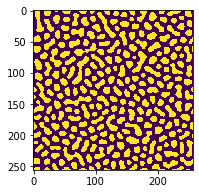

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(261),plt.imshow(im_bin_inv)

In [0]:
a=100
print(a)
b=a/2
print(b)

100
50.0


count= 0
j= 0
j= 1
j= 2


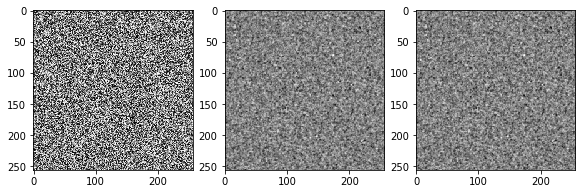

In [94]:
#512→256にしたい
#511→255
#256→128
#0:510→0:254
#磁気ドメインパターン形成TDGL方程式 多くのファイルを生成
#初期値の用意

count=1
img_size=256 #奇数は切り捨て
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
from scipy import signal
import os
from PIL import Image
import numpy as np
%matplotlib inline

for count in range(1):
 
 print("count=",count)
 Phi_r_ini=np.ones([500,img_size,img_size],dtype=np.complex)
 Phi_r=Phi_r_ini+0.1*np.random.rand(img_size,img_size)
 Phi_k=np.zeros([500,img_size,img_size],dtype=np.complex)
 Sum_Moment=np.zeros(500)
 diff_Moment=np.zeros(500)
 Real_Phi_r=np.zeros([500,img_size,img_size])
 Mag_Field=np.zeros(500)
 #repetition=26#不完全なまま
 repetition=3
 #1400,14000,140000
 #時間ステップの用意
 delta_t=0.1
 
 #betaの用意
 beta=4.0 #デフォ
 #beta=3
 
 #alphaの用意
 alpha=2.5#デフォ
 #alpha=1.6
 
 #gammaの用意
 gamma=2.0/np.pi#デフォ

 #k=(k_x,k_y)の用意
 k_x=np.linspace(0,img_size-1,img_size)
 for i in range(len(k_x)):
     if i>len(k_x)//2:
         k_x[i]=k_x[i]-len(k_x)
     else:
         k_x[i]=k_x[i]
 
 k_y=copy.copy(k_x)
 kk_sqrt=np.zeros([img_size,img_size])
 for i in range(img_size):
     for j in range(img_size):
         kk_sqrt[j,i]=np.sqrt(4.0*np.pi**2*k_x[i]*k_x[i]/(len(k_x)*len(k_x))+4.0*np.pi**2*k_y[j]*k_y[j]/(len(k_x)*len(k_x)))
 
         #ここはkの絶対値PRE(6)式
 
 
 #1/(1+beta*(k_x^2+k_y^2)*delta_t)
 keisu=np.zeros([img_size,img_size])
 for i in range(img_size):
     for j in range(img_size):
         keisu[j,i]=1/(1+beta*(4.0*np.pi**2*k_x[i]*k_x[i]/(len(k_x)*len(k_x))+4.0*np.pi**2*k_y[j]*k_y[j]/(len(k_x)*len(k_x)))*delta_t)
 
 #keisu=Lambda*keisu        
 
 #Lambda_ini=np.ones([512,512])
 Lambda_ini=np.ones([img_size,img_size])
 myu_0=0.3
 #np.random.seed(10)
 
 Lambda=Lambda_ini+0.25*np.random.normal(0, myu_0, (img_size,img_size))
 Lambda_FFT=np.fft.fft2(Lambda)
 #Lambda_k_shift=np.fft.fftshift(Lambda_FFT)
 
 #Lambda_arr=np.loadtxt('testM.txt')#磁気異方性が完全ランダムではないときは？
 #Lambda_arr_Norm=Lambda_arr/255
 #Lambda=(Lambda_ini+Lambda_arr_Norm)*0.25*np.random.normal(0, myu_0, (512,512))
 #Lambda=Lambda_ini+0.25*Lambda_arr_Norm
 
 #a0,a1の用意
 a0=4.0
 a1=2.0*np.pi
 
 #G_kの用意
 G_k=np.zeros([img_size,img_size])
 G_k=a0-a1*kk_sqrt
 
 #磁場の用意
 h_ini_r=1.4
 #h_ini_r=10
 Mag_Field[0]=h_ini_r
 h=np.ones([img_size,img_size])
 h=h_ini_r*h
 #print(h)
 H_k=np.fft.fft2(h)
 v=np.ones([img_size,img_size])
 #h_v=0.0100*v
 #h_v=0.00100*v
 h_v=0.000100*v
 
 
 
 #初期磁化の値
 Real_Phi_r[0,:,:]=np.real(Phi_r[0,:,:])
 Sum_Moment[0]=np.sum(Real_Phi_r[0,:,:])/len(k_x)**2 
 
 #JPSJ(2005)013002.(7)式の用意:時刻t=0のもの
 Phi_r3=Phi_r[0,:,:]*Phi_r[0,:,:]*Phi_r[0,:,:]
 First=Lambda*(Phi_r[0,:,:]-Phi_r3)
 #First=(Phi_r[0,:,:]-Phi_r3)
 
 #上式のFFT　ここのたたみ込みの計算を位相移動法で行う→打ち切り法へ変更(2019/05/27)-len(k_x)/2, len(k_x)/2
 First_FFT=np.fft.fft2(First)
 Phi_k[0,:,:]=np.fft.fft2(Phi_r[0,:,:])
 for l in range(-(img_size)//2,(img_size)//2):
     for k in range(-(img_size)//2,(img_size)//2):
         if k**2+l**2 > 170**2:
             First_FFT[k,l]=0.0+0.0j
         else:
             First_FFT[k,l]=First_FFT[k,l]
 
 #時刻t+ΔtのPhi_k k=(k_x,k_y)とk^2=k_x^2+k_y^2これの平方根sを用意する
 
 for j in range(repetition):
     print("j=",j)
     if j==0:
         Phi_k_temp=Phi_k[0,:,:]
         Phi_k[0,:,:]=Phi_k_temp
     else:
         Phi_k_temp=Phi_k[i+1,:,:]
         Phi_k[0,:,:]=Phi_k_temp
         Sum_Moment_temp=Sum_Moment[i+1]
         Sum_Moment[0]=Sum_Moment_temp
         diff_Moment_temp=diff_Moment[i+1]
         diff_Moment[0]=diff_Moment_temp
         Mag_Field_temp=Mag_Field[i+1]
         Mag_Field[0] = Mag_Field_temp
 
     for i in range(499):
         #print("i=",i)
         Phi_k[i+1,:,:]=keisu*(delta_t*(alpha*First_FFT+H_k-gamma*G_k*Phi_k[i,:,:])+Phi_k[i,:,:])
         Phi_r[i+1,:,:]=np.fft.ifft2(Phi_k[i+1,:,:])
         #print('Phi_r[i+1,:,:]=',Phi_r[i+1,:,:])
         #境界条件＆周期境界
         #Phi_r[i+1,0:511,511]=Phi_r[i+1,0:511,0]
         #Phi_r[i+1,0,0:511]=Phi_r[i+1,0:511,0]
         #Phi_r[i+1,511,0:511]=Phi_r[i+1,0,0:511]
         
         #Phi_r[i+1,1:510,511]=Phi_r[i+1,1:510,0]
         #Phi_r[i+1,511,511]=Phi_r[i+1,0,0]
         #Phi_r[i+1,0,511]=Phi_r[i+1,0,0]
 
         Phi_r[i+1,img_size-1,1:img_size-2]=Phi_r[i+1,0,1:img_size-2]
         Phi_r[i+1,1:img_size-2,img_size-1]=Phi_r[i+1,1:img_size-2,0]
         Phi_r[i+1,img_size-1,img_size-1]=Phi_r[i+1,0,0]
         Phi_r[i+1,0,img_size-1]=Phi_r[i+1,0,0]
         Phi_r[i+1,img_size-1,0]=Phi_r[i+1,0,0]
         
         Phi_r3=Phi_r[i+1,:,:]*Phi_r[i+1,:,:]*Phi_r[i+1,:,:]
         First=Lambda*(Phi_r[i+1,:,:]-Phi_r3)
         First_FFT=np.fft.fft2(First)
 
         for l in range(-(img_size)//2,(img_size)//2):
             for k in range(-(img_size)//2,(img_size)//2):
                 if l**2+k**2 > 170**2:
                     First_FFT[k,l]=0.0+0.0j
                 else:
                     First_FFT[k,l]=First_FFT[k,l]
 
         h_temp=h-delta_t*h_v
         if h_temp[0,0] <= 1.0e-5:
             h=h_temp*0.0
         else:
             h=h_temp
         Mag_Field[i+1]=h[0,0]
         H_k=np.fft.fft2(h)
         Real_Phi_r[i+1,:,:]=np.real(Phi_r[i+1,:,:])
         Sum_Moment[i+1]=np.sum(Real_Phi_r[i+1,:,:])/len(k_x)**2
         diff=np.abs(Real_Phi_r[i+1,:,:]-Real_Phi_r[i,:,:])
         diff_Moment[i+1]=np.abs(Sum_Moment[i+1]-Sum_Moment[i])
         
         #j回目のデータを保存する
         #path='C:/TDGL/IMAGE2' #hikakinのときは\home\iinoでOK？
         #os.makedirs(path, exist_ok=True)
         #np.save("C:/TDGL/IMAGE2/hv051_dt0p1_"+"%03.f"%(j)+"_%03.f"%(i+1)+".npy",np.real(Phi_r[i+1,:,:]))
         #np.savetxt("C:/TDGL/IMAGE2/hv051_dt0p1_SaMoment_"+"%03.f"%(j)+".txt",np.array([Mag_Field,Sum_Moment]).T, delimiter=" ")
         #np.savetxt("C:/TDGL/IMAGE2/hv051_dt0p1_DifMoment_"+"%03.f"%(j)+".txt",np.array([Mag_Field,diff_Moment]).T, delimiter=" ")
         binary=np.real(Phi_r[i,:,:])
         th=0.00
         im_bin=(binary>th)*255
         im_bin_inv=cv2.bitwise_not(im_bin)+256
         pilImg = Image.fromarray(np.uint8(im_bin_inv))
            
        
         
         pilImg.save("/home/iino/sandbox/output/%01.f"%(count+1)+"kaime/%0.f"%(j)+"/%03.f"%(i)+".png")
         #pilImg.save("/content/v=0.001/2kaime/%03.f"%(i)+".png")
         #pilImg.save("%03.f"%(i)+".png")
         #count=count+1
 
 
 plt.figure(figsize=(20, 10))
 plt.subplot(261),plt.imshow(np.real(Phi_r[0,:,:]),cmap='gray')
 plt.subplot(262),plt.imshow(np.real(Phi_r[249,:,:]),cmap='gray')
 plt.subplot(263),plt.imshow(np.real(Phi_r[499,:,:]),cmap='gray')
 #plt.subplot(264),plt.imshow(np.real(Phi_r[79,:,:]),cmap='gray')
 #plt.subplot(265),plt.imshow(np.real(Phi_r[899,:,:]),cmap='gray')
 #plt.subplot(266),plt.imshow(np.real(Phi_r[999,:,:]),cmap='gray')

 #GoogleColabでGPUアリでやったときの目安時間(繰り返し1回あたり)
 #512→120秒ぐらい
 #256→30秒ぐらい
 #128→10秒ぐらい

count= 0
[[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 ...
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]]
j= 0


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/0/468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 1


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/258.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/259.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/343.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/385.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/1/469.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 2


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/2/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 3


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/3/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 4


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/4/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 5


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/048.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/090.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/132.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/258.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/5/468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 6


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/6/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 7


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/7/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 8


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/8/468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 9


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/9/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaco

j= 10


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/10/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

j= 11


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/090.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/132.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/258.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/342.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/343.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/384.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/385.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/426.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/427.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/468.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/11/469.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

j= 12


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/085.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/127.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/169.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/211.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/253.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/254.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/255.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/295.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/296.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/297.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/298.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/338.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/339.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/340.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/341.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/379.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/380.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/381.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/382.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/383.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/421.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/423.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/424.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/425.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/463.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/464.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/465.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/466.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/12/467.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

j= 13


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/048.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/086.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/087.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/088.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/089.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/090.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/128.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/129.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/130.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/131.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/132.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/170.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/171.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/172.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/173.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/174.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/212.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/213.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/214.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/216.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/256.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/257.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/258.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/259.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/260.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/299.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/300.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/301.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/302.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/303.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/366.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/367.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/368.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/369.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/370.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/409.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/410.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/411.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/412.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/413.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/497.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/13/498.png is a low contrast image
  warn('%s is a low contrast image' % fname)


j= 14


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/043.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/044.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/045.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/046.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/047.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/154.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/155.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/156.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/157.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/1kaime_0.001/14/158.png is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\ProgramData\

j= 15
j= 16
j= 17
j= 18
j= 19
j= 20
j= 21
j= 22
j= 23
j= 24
j= 25
j= 26
j= 27
j= 28
j= 29
j= 30
j= 31
j= 32
j= 33
j= 34
j= 35
j= 36
j= 37
j= 38
j= 39
j= 40
j= 41
j= 42
j= 43
j= 44
j= 45
j= 46
j= 47
j= 48
j= 49
j= 50
j= 51
j= 52
j= 53
j= 54
j= 55
j= 56
j= 57
j= 58
j= 59
count= 1
[[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 ...
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]]
j= 0


C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: C:/TDGL/sandbox/20191213/2kaime_0.001/0/001.png is a low contrast image
  warn('%s is a low contrast image' % fname)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/TDGL/sandbox/20191213/2kaime_0.001/0/001.png'

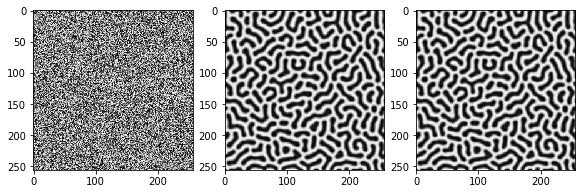

In [6]:
#import cupy
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
from scipy import signal
import os
from PIL import Image
import numpy as np
%matplotlib inline
import skimage
from skimage import io

#512→256にしたい
#511→255
#256→128
#0:510→0:254
#磁気ドメインパターン形成TDGL方程式 多くのファイルを生成
#初期値の用意

count=1
img_size=256 #奇数は切り捨て
import numpy as np
from matplotlib import pyplot as plt
import cv2
import copy
from scipy import signal
import os
from PIL import Image
import numpy as np
%matplotlib inline

for count in range(2):
 
 print("count=",count)
 Phi_r_ini=np.ones([500,img_size,img_size],dtype=np.complex)
 Phi_r=Phi_r_ini+0.1*np.random.rand(img_size,img_size)
 Phi_k=np.zeros([500,img_size,img_size],dtype=np.complex)
 Sum_Moment=np.zeros(500)
 diff_Moment=np.zeros(500)
 Real_Phi_r=np.zeros([500,img_size,img_size])
 Mag_Field=np.zeros(500)
 #repetition=26#不完全なまま
 repetition=60
 #1400,14000,140000
 #時間ステップの用意
 delta_t=0.1
 
 #betaの用意
 beta=4.0 #デフォ
 #beta=3
 
 #alphaの用意
 alpha=2.5#デフォ
 #alpha=1.6
 
 #gammaの用意
 gamma=2.0/np.pi#デフォ

 #k=(k_x,k_y)の用意
 k_x=np.linspace(0,img_size-1,img_size)
 for i in range(len(k_x)):
     if i>len(k_x)//2:
         k_x[i]=k_x[i]-len(k_x)
     else:
         k_x[i]=k_x[i]
 
 k_y=copy.copy(k_x)
 kk_sqrt=np.zeros([img_size,img_size])
 for i in range(img_size):
     for j in range(img_size):
         kk_sqrt[j,i]=np.sqrt(4.0*np.pi**2*k_x[i]*k_x[i]/(len(k_x)*len(k_x))+4.0*np.pi**2*k_y[j]*k_y[j]/(len(k_x)*len(k_x)))
 
         #ここはkの絶対値PRE(6)式
 
 
 #1/(1+beta*(k_x^2+k_y^2)*delta_t)
 keisu=np.zeros([img_size,img_size])
 for i in range(img_size):
     for j in range(img_size):
         keisu[j,i]=1/(1+beta*(4.0*np.pi**2*k_x[i]*k_x[i]/(len(k_x)*len(k_x))+4.0*np.pi**2*k_y[j]*k_y[j]/(len(k_x)*len(k_x)))*delta_t)
 
 #keisu=Lambda*keisu        
 
 #Lambda_ini=np.ones([512,512])
 Lambda_ini=np.ones([img_size,img_size])
 myu_0=0.3
 #np.random.seed(10)
 
 Lambda=Lambda_ini+0.25*np.random.normal(0, myu_0, (img_size,img_size))
 Lambda_FFT=np.fft.fft2(Lambda)
 #Lambda_k_shift=np.fft.fftshift(Lambda_FFT)
 
 #Lambda_arr=np.loadtxt('testM.txt')#磁気異方性が完全ランダムではないときは？
 #Lambda_arr_Norm=Lambda_arr/255
 #Lambda=(Lambda_ini+Lambda_arr_Norm)*0.25*np.random.normal(0, myu_0, (512,512))
 #Lambda=Lambda_ini+0.25*Lambda_arr_Norm
 
 #a0,a1の用意
 a0=4.0
 a1=2.0*np.pi
 
 #G_kの用意
 G_k=np.zeros([img_size,img_size])
 G_k=a0-a1*kk_sqrt
 
 #磁場の用意
 h_ini_r=1.4
 #h_ini_r=10
 Mag_Field[0]=h_ini_r
 h=np.ones([img_size,img_size])
 h=h_ini_r*h
 #print(h)
 H_k=np.fft.fft2(h)
 v=np.ones([img_size,img_size])
 #h_v=0.0100*v
 h_v=0.00100*v
 #h_v=0.000100*v
 
 
 
 #初期磁化の値
 Real_Phi_r[0,:,:]=np.real(Phi_r[0,:,:])
 Sum_Moment[0]=np.sum(Real_Phi_r[0,:,:])/len(k_x)**2 
 
 #JPSJ(2005)013002.(7)式の用意:時刻t=0のもの
 Phi_r3=Phi_r[0,:,:]*Phi_r[0,:,:]*Phi_r[0,:,:]
 First=Lambda*(Phi_r[0,:,:]-Phi_r3)
 #First=(Phi_r[0,:,:]-Phi_r3)
 
 #上式のFFT　ここのたたみ込みの計算を位相移動法で行う→打ち切り法へ変更(2019/05/27)-len(k_x)/2, len(k_x)/2
 First_FFT=np.fft.fft2(First)
 Phi_k[0,:,:]=np.fft.fft2(Phi_r[0,:,:])
 for l in range(-(img_size)//2,(img_size)//2):
     for k in range(-(img_size)//2,(img_size)//2):
         if k**2+l**2 > 170**2:
             First_FFT[k,l]=0.0+0.0j
         else:
             First_FFT[k,l]=First_FFT[k,l]
 
 #時刻t+ΔtのPhi_k k=(k_x,k_y)とk^2=k_x^2+k_y^2これの平方根sを用意する
 print(h_v)
 for j in range(repetition):
     print("j=",j)
     if j==0:
         Phi_k_temp=Phi_k[0,:,:]
         Phi_k[0,:,:]=Phi_k_temp
     else:
         Phi_k_temp=Phi_k[i+1,:,:]
         Phi_k[0,:,:]=Phi_k_temp
         Sum_Moment_temp=Sum_Moment[i+1]
         Sum_Moment[0]=Sum_Moment_temp
         diff_Moment_temp=diff_Moment[i+1]
         diff_Moment[0]=diff_Moment_temp
         Mag_Field_temp=Mag_Field[i+1]
         Mag_Field[0] = Mag_Field_temp
 
     for i in range(499):
         #print("i=",i)
         Phi_k[i+1,:,:]=keisu*(delta_t*(alpha*First_FFT+H_k-gamma*G_k*Phi_k[i,:,:])+Phi_k[i,:,:])
         Phi_r[i+1,:,:]=np.fft.ifft2(Phi_k[i+1,:,:])
         #print('Phi_r[i+1,:,:]=',Phi_r[i+1,:,:])
         #境界条件＆周期境界
         #Phi_r[i+1,0:511,511]=Phi_r[i+1,0:511,0]
         #Phi_r[i+1,0,0:511]=Phi_r[i+1,0:511,0]
         #Phi_r[i+1,511,0:511]=Phi_r[i+1,0,0:511]
         
         #Phi_r[i+1,1:510,511]=Phi_r[i+1,1:510,0]
         #Phi_r[i+1,511,511]=Phi_r[i+1,0,0]
         #Phi_r[i+1,0,511]=Phi_r[i+1,0,0]
 
         Phi_r[i+1,img_size-1,1:img_size-2]=Phi_r[i+1,0,1:img_size-2]
         Phi_r[i+1,1:img_size-2,img_size-1]=Phi_r[i+1,1:img_size-2,0]
         Phi_r[i+1,img_size-1,img_size-1]=Phi_r[i+1,0,0]
         Phi_r[i+1,0,img_size-1]=Phi_r[i+1,0,0]
         Phi_r[i+1,img_size-1,0]=Phi_r[i+1,0,0]
         
         Phi_r3=Phi_r[i+1,:,:]*Phi_r[i+1,:,:]*Phi_r[i+1,:,:]
         First=Lambda*(Phi_r[i+1,:,:]-Phi_r3)
         First_FFT=np.fft.fft2(First)
 
         for l in range(-(img_size)//2,(img_size)//2):
             for k in range(-(img_size)//2,(img_size)//2):
                 if l**2+k**2 > 170**2:
                     First_FFT[k,l]=0.0+0.0j
                 else:
                     First_FFT[k,l]=First_FFT[k,l]
 
         h_temp=h-delta_t*h_v
         if h_temp[0,0] <= 1.0e-5:
             h=h_temp*0.0
         else:
             h=h_temp
         Mag_Field[i+1]=h[0,0]
         H_k=np.fft.fft2(h)
         Real_Phi_r[i+1,:,:]=np.real(Phi_r[i+1,:,:])
         Sum_Moment[i+1]=np.sum(Real_Phi_r[i+1,:,:])/len(k_x)**2
         diff=np.abs(Real_Phi_r[i+1,:,:]-Real_Phi_r[i,:,:])
         diff_Moment[i+1]=np.abs(Sum_Moment[i+1]-Sum_Moment[i])
         
         #j回目のデータを保存する
         #path='C:/TDGL/IMAGE2' #hikakinのときは\home\iinoでOK？
         #os.makedirs(path, exist_ok=True)
         #np.save("C:/TDGL/IMAGE2/hv051_dt0p1_"+"%03.f"%(j)+"_%03.f"%(i+1)+".npy",np.real(Phi_r[i+1,:,:]))
         #np.savetxt("C:/TDGL/IMAGE2/hv051_dt0p1_SaMoment_"+"%03.f"%(j)+".txt",np.array([Mag_Field,Sum_Moment]).T, delimiter=" ")
         #np.savetxt("C:/TDGL/IMAGE2/hv051_dt0p1_DifMoment_"+"%03.f"%(j)+".txt",np.array([Mag_Field,diff_Moment]).T, delimiter=" ")
         #binary=np.real(Phi_r[i,:,:])
         #th=0.00
         #im_bin=(binary>th)*255
         #im_bin_inv=cv2.bitwise_not(im_bin)+256
         #pilImg = Image.fromarray(np.uint8(im_bin_inv))
            
        
         #pilImg.save("C:/TDGL/colab/v=0.001/%01.f"%(count+1)+"kaime/%0.f"%(j)+"/%03.f"%(i)+".png")
         #pilImg.save("/home/iino/sandbox/output/%01.f"%(count+1)+"kaime/%0.f"%(j)+"/%03.f"%(i)+".png")
         #pilImg.save("/content/%01.f"%(count+9)+"kaime/%0.f"%(j)+"/%03.f"%(i)+".png")
         #pilImg.save("/content/v=0.001/2kaime/%03.f"%(i)+".png")
         #pilImg.save("%03.f"%(i)+".png")
         #count=count+1
         if(i!=0):
          img = skimage.img_as_ubyte(np.real(Phi_r[i,:,:]))
          #print(img)
          io.imsave("C:/TDGL/sandbox/20191213/%01.f"%(count+1)+"kaime_0.001/%0.f"%(j)+"/%03.f"%(i)+".png", img)#v=0.001
 




 plt.figure(figsize=(20, 10))
 plt.subplot(261),plt.imshow(np.real(Phi_r[0,:,:]),cmap='gray')
 plt.subplot(262),plt.imshow(np.real(Phi_r[249,:,:]),cmap='gray')
 plt.subplot(263),plt.imshow(np.real(Phi_r[499,:,:]),cmap='gray')
 #plt.subplot(264),plt.imshow(np.real(Phi_r[79,:,:]),cmap='gray')
 #plt.subplot(265),plt.imshow(np.real(Phi_r[899,:,:]),cmap='gray')
 #plt.subplot(266),plt.imshow(np.real(Phi_r[999,:,:]),cmap='gray')

 #GoogleColabでGPUアリでやったときの目安時間(繰り返し1回あたり)
 #512→120秒ぐらい
 #256→30秒ぐらい
 #128→10秒ぐらい

In [1]:
ls

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 2605-E374 です

 C:\TDGL のディレクトリ

2019/11/12  13:38    <DIR>          .
2019/11/12  13:38    <DIR>          ..
2019/10/09  23:13             1,203 .gitignore
2019/11/04  19:30    <DIR>          .ipynb_checkpoints
2019/10/27  18:36    <DIR>          191027
2019/10/28  04:40           679,120 255_MOUSE.ipynb
2019/10/27  19:33           678,693 255ver.ipynb
2019/11/04  18:42           195,149 bandicam 2019-11-04 18-42-35-594.jpg
2019/11/06  14:14           235,241 bandicam 2019-11-06 14-14-02-955.jpg
2019/11/06  15:22            69,495 bandicam 2019-11-06 15-22-46-236.jpg
2019/11/06  17:40            12,380 bandicam 2019-11-06 17-40-33-725.jpg
2019/11/06  17:41            41,811 bandicam 2019-11-06 17-41-16-338.jpg
2019/11/06  17:44            56,726 bandicam 2019-11-06 17-44-04-322.jpg
2019/11/12  13:28    <DIR>          colab
2019/11/05  23:04                 0 Google colabのGPUでやれ.txt
2019/11/01  17:54    <DIR>          hamano
2019/11/04  11:2

In [0]:
#!zip -r 10kaime.zip 10kaime
#!zip -r 1kaime.zip 1kaime
#!zip -r 2kaime.zip 2kaime
!zip -r 3kaime.zip 3kaime
!zip -r 4kaime.zip 4kaime
!zip -r 5kaime.zip 5kaime
!zip -r 6kaime.zip 6kaime
!zip -r 7kaime.zip 7kaime
#!zip -r 8kaime.zip 8kaime
#!zip -r 9kaime.zip 9kaime

  adding: 3kaime/ (stored 0%)
  adding: 3kaime/015.png (stored 0%)
  adding: 3kaime/153.png (stored 0%)
  adding: 3kaime/242.png (stored 0%)
  adding: 3kaime/064.png (stored 0%)
  adding: 3kaime/204.png (stored 0%)
  adding: 3kaime/398.png (stored 0%)
  adding: 3kaime/380.png (stored 0%)
  adding: 3kaime/029.png (stored 0%)
  adding: 3kaime/042.png (stored 0%)
  adding: 3kaime/394.png (stored 0%)
  adding: 3kaime/455.png (stored 0%)
  adding: 3kaime/318.png (stored 0%)
  adding: 3kaime/317.png (stored 0%)
  adding: 3kaime/316.png (stored 0%)
  adding: 3kaime/381.png (stored 0%)
  adding: 3kaime/469.png (stored 0%)
  adding: 3kaime/352.png (stored 0%)
  adding: 3kaime/263.png (stored 0%)
  adding: 3kaime/168.png (stored 0%)
  adding: 3kaime/484.png (stored 0%)
  adding: 3kaime/441.png (stored 0%)
  adding: 3kaime/389.png (stored 0%)
  adding: 3kaime/363.png (stored 0%)
  adding: 3kaime/179.png (stored 0%)
  adding: 3kaime/424.png (stored 0%)
  adding: 3kaime/417.png (stored 0%)
  adding

In [0]:
ls

10kaime/     2kaime/     4kaime/     6kaime/     8kaime/
10kaime.zip  2kaime.zip  4kaime.zip  6kaime.zip  8kaime.zip
1kaime/      3kaime/     5kaime/     7kaime/     9kaime/
1kaime.zip   3kaime.zip  5kaime.zip  7kaime.zip  9kaime.zip


In [0]:
binary=np.real(Phi_r[499,:,:])
th=0.00
im_bin=(binary>th)*255
im_bin_inv=cv2.bitwise_not(im_bin)+256
print(im_bin_inv)
len(im_bin_inv)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [255 255   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


256

In [36]:
import os

#os.makedirs('/home/iino/sandbox/outout/1kaime/a', exist_ok=True)
j=0
for j in range(500):
 #path1='/home/iino/sandbox/outout/1kaime/%02.f"%(j)+"'
 #path2='/home/iino/sandbox/outout/2kaime/%02.f"%(j)+"'
 #path3='/home/iino/sandbox/outout/3kaime/%02.f"%(j)+"'
 #path4='/home/iino/sandbox/outout/4kaime/%02.f"%(j)+"'
 #path5='/home/iino/sandbox/outout/5kaime/%02.f"%(j)+"'
 #path6='/home/iino/sandbox/outout/6kaime/%02.f"%(j)+"'
 #path7='/home/iino/sandbox/outout/7kaime/%02.f"%(j)+"'
 #path8='/home/iino/sandbox/outout/8kaime/%02.f"%(j)+"'
 #path9='/home/iino/sandbox/outout/9kaime/%02.f"%(j)+"'
 #path10='/home/iino/sandbox/outout/10kaime'
 #path10='/home/iino/sandbox/outout/10kaime/%02.f"%(j)+"'
 os.makedirs('./%01.f"%(j)"', exist_ok=True)
 os.makedirs(path2, exist_ok=True)
 os.makedirs(path3, exist_ok=True)
 os.makedirs(path4, exist_ok=True)
 os.makedirs(path5, exist_ok=True)
 os.makedirs(path6, exist_ok=True)
 os.makedirs(path7, exist_ok=True)
 os.makedirs(path8, exist_ok=True)
 os.makedirs(path9, exist_ok=True)
 os.makedirs(path10, exist_ok=True)

In [95]:
cd ../1kaime

/home/iino/sandbox/output/1kaime


In [92]:
for i in range(0,1401):
	if not os.path.exists(str(i)):
		os.mkdir(str(i))

In [102]:
ls

In [101]:
cd ../3

/home/iino/sandbox/output/1kaime/3


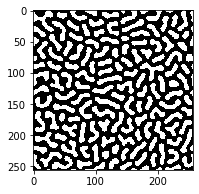

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(261),plt.imshow(im_bin_inv,cmap='gray')
pilImg = Image.fromarray(np.uint8(im_bin_inv))
pilImg.save("/content/%03.f"%(i)+".png")